# Семинар 5 - Морфологические преобразования, бинаризация, выделение границ и контуров

***

In [11]:
from pathlib import Path

import numpy as np

import cv2

import matplotlib.pyplot as plt

from skimage.color import rgb2gray
from skimage.io import imread, imshow
from skimage.morphology import erosion, dilation, opening


## Часть 1 - Сегментация листьев с использованием морфологических операций

Источник - https://medium.com/swlh/image-processing-with-python-morphological-operations-26b7006c0359

In [ ]:
leaves = imread('data/leaves.jpg')

fig, axis = plt.subplots(1,2, figsize=(12,6))
axis[0].imshow(leaves);
axis[0].set_title('Original Image')

grayscale = rgb2gray(leaves)
axis[1].imshow(grayscale, cmap='gray')
axis[1].set_title('Grayscale Image')
plt.tight_layout()

Попробуем преобразовать изображение в бинарное по порогу:

In [ ]:
fig, axis = plt.subplots(1,2, figsize=(12,6))

axis[0].imshow(grayscale)
axis[0].set_title('Grayscale Image')

binary_w_threshold = grayscale < 0.15
axis[1].imshow(binary_w_threshold)
axis[1].set_title('Binarized Image')
plt.tight_layout()

Несмотря на то, что мы применили низкое значение для порогового значения двоичного изображения, двоичное изображение все равно остается «грязным». Это из-за виноградных лоз и решетчатого каркаса того же оттенка. К счастью, лозы и решетчатый каркас намного тоньше листьев — поэтому мы можем применять морфологические операции.

Давайте определим структурный элемент. Это может быть массив любого размера — при условии, что он имеет меньшую форму, чем входное изображение.

In [ ]:
element = np.array([[0,1,0],
                    [1,1,1],
                    [0,1,0]])
plt.figure(figsize=(3,3))
plt.imshow(element, cmap='gray');

Однако наше изображение имеет размер более 3000*2500 пикселей. Таким образом, мы будем использовать элемент 7x7, потому что.

Эмпирическое правило при настройке элемента структурирования заключается в том, чтобы просмотреть объекты, которые вы хотите удалить, и объекты, которые вы хотите оставить.

Форма элемента структурирования должна быть больше пикселей объектов, которые вы хотите удалить, и меньше пикселей объектов, которые вы хотите оставить.

In [ ]:
element = np.array([[0,0,0,0,0,0,0],
                    [0,0,1,1,1,0,0],
                    [0,1,1,1,1,1,0],
                    [0,1,1,1,1,1,0],
                    [0,1,1,1,1,1,0],
                    [0,0,1,1,1,0,0],
                    [0,0,0,0,0,0,0]])

plt.figure(figsize=(7,7))
plt.imshow(element, cmap='gray');

Используя этот структурный элемент, мы можем применять последовательные операции эрозии, чтобы удалить лозы и решетчатый каркас.

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(erosion(binary_w_threshold, element))
plt.title('Eroded Image');

Давайте проделаем эрозию несколько раз.

In [14]:
def multi_ero(im, num, element=element):
    for i in range(num):
        im = erosion(im, element)
    return im

In [ ]:
plt.figure(figsize=(6,6))
multi_eroded = multi_ero(binary_w_threshold, 2, element)
plt.imshow(multi_eroded)
plt.title('Multi-Eroded Image');

После последовательной эрозии большая часть ненужных объектов и артефактов разрушается.

Однако обратите внимание, что в некоторых местах все еще слышен незначительный шум. Мы можем удалить это, применив операцию *opening*.

In [ ]:
plt.figure(figsize=(6,6))
opened = opening(multi_eroded, element)
plt.imshow(opened)
plt.title('Multi-Eroded and Opened Image');

Теперь, поскольку мы применили последовательную эрозию, размер и форма объектов стали меньше оригинала.

Чтобы приблизительно восстановить их размер, нам нужно применить последовательное расширение столько же раз, сколько раз мы применили эрозию.

Более того, мы должны использовать один и тот же элемент структурирования, чтобы восстановление формы объекта было максимально приближено к оригиналу.

In [17]:
def multi_dil(im, num, element=element):
    for i in range(num):
        im = dilation(im, element)
    return im

In [ ]:
plt.figure(figsize=(6,6))
multi_diluted = multi_dil(opened, 2, element)
plt.imshow(multi_diluted)
plt.title('Multi-Eroded, Opened and then Dilated Image');

## Часть 2

В рамках данного семинара предлагается поработать с изображениями с конкурса по анализу данных Proppant Check Challenge. Описание задачи и данных можно посмотреть на сайте соревнования: https://boosters.pro/championship/RPCC

Ранее можно было скачать весь датасет https://boosters.pro/api/ch/files/pub/RPCC_train.zip, однако по состоянию на 01.02.2023 эта ссылка возвращает 404. Однако для выполнения данного задания весь датасет и не нужен, достаточно будет "чудом уцелевшего" изображения `./data/rpcc_sample.png` (его разрешение ниже, чем в оригинальном датасете, но на общий ход решения это не влияет).

In [30]:
IMG_PATH = "data/rpcc_sample.png"
TEMPLATE_PATH = "data/rpcc_template.png"

### Работа с изображением

Основным заданием будет создание алгоритма предобработки изображений для решения следующей задачи:

**Входные данные:** фотография листа бумаги с нанесенным шаблоном и рассыпанным пропаннатом

**Выходные данные:** кроп входного изображения, содержащего только область с проппанатом.

In [31]:
img = cv2.imread(IMG_PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

Изображения в датасете сняты на камеру мобильного телефона под некоторым углом и с некоторого расстояния:

In [ ]:
plt.figure(figsize=[10, 10])
plt.imshow(img)

На всех фотографиях снят лист бумаги с распечатанным шаблоном и рассыпанным на нем проппанатом. Шаблон извествен:

In [33]:
template = cv2.imread(TEMPLATE_PATH)

In [ ]:
plt.figure(figsize=[15, 10])
plt.imshow(template)

Далее рассмотрим примеры использования алгоритмов, которые могут быть полезны при решении данной задачи извлечения области с проппанатом.

### Бинаризация

Туториал: https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html

Реализация обычной пороговой бинаризации в OpenCV представлена функцией `cv2.threshold` с флагом `cv2.THRESH_BINARY`. Другие флаги, такие как `cv2.THRESH_TRUNC`
`cv2.THRESH_TOZERO` определяют, будут ли изменены значения ниже или выше порога

In [35]:
ret, th_const = cv2.threshold(
    gray,                   # входное изображение
    128,                    # порог бинаризации
    255,                    # максимальное значения пикселя изображения
    cv2.THRESH_BINARY       # способ бинаризации (cv2.THRESH_BINARY, cv2.THRESH_BINARY_INV, cv2.THRESH_TRUNC, cv2.THRESH_TOZERO, cv2.THRESH_TOZERO_INV)
)

`ret` - пороговое значение, которое было использовано. При использовании `cv2.THRESH_BINARY` в `ret` будет возвращено значение порога, которое вы сами же и указали.

In [ ]:
ret

In [ ]:
plt.figure(figsize=[10, 10])
plt.imshow(th_const, cmap='Greys_r')

### Вопрос

_Это не оцениваемое задание, просто "на подумать"._

В чем заключается недостаток обычной бинаризации по константному порогу?

**Ответ:** 

Очевидно, что результат неудовлетворителен. Впрочем, можно попробовать подобрать оптимальный порог вручную, основываясь на визуальной оценке качества бинаризации, или осуществить поиск оптимального порога по **методу Отсу**. Делается это передачей дополнительного флага `cv2.THRESH_OTSU`:

In [40]:
ret, th_otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

In [ ]:
print('Оптимальный порог бинаризации по Отсу: ', ret)

In [ ]:
plt.figure(figsize=[10, 10])
plt.imshow(th_otsu, cmap='Greys_r')

Уже значительно лучше. Но попробуем адаптивную бинаризацию

### Адаптивная бинаризация

Туториал: https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html

Адаптивная бинаризация в OpenCV представлена методом `cv2.adaptiveThreshold`:

In [43]:
th_adaptive = cv2.adaptiveThreshold(
    gray,                        # входное изображение
    255,                         # максимальное значения пикселя изображения
    cv2.ADAPTIVE_THRESH_MEAN_C,  # способ вычисления порога (cv2.ADAPTIVE_THRESH_MEAN_C - среднее, cv.ADAPTIVE_THRESH_GAUSSIAN_C - взвешенное среднее, с весами по гауссиане)
    cv2.THRESH_BINARY,           # способ бинаризации (те же, что и для неадаптивной)
    51,                           # размер окрестности пикселя, рассматриваемой при вычислении порога (должна быть нечетной)
    0                            # это значение вычитается из вычисленного порога, полученная величина - фактический порог бинаризации
)

In [ ]:
plt.figure(figsize=[10, 10])
plt.imshow(th_adaptive, cmap='Greys_r')

Получилось не очень, но зато у нас теперь есть данные, чтобы поработать с морфологическими преобразованиями.

### Вопрос

Исходя из результатов работы адаптивной бинаризации, попробуйте определить, какие характеристики исходного изображения могли привести к таким результатам?

**Ответ:**

### Морфологические преобразования

Туториал: https://docs.opencv.org/3.4/d9/d61/tutorial_py_morphological_ops.html

Попробуем 'очистить' результаты адаптивной бинаризации, сохранив только ярко выраженные границы. Достигнуть этого можно с помощью морфологического преобразования 'opening' (открытия, раскрытия):

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
th_adaptive_cl = cv2.morphologyEx(th_adaptive, cv2.MORPH_CLOSE, kernel, None, None, 2)
print('Ядро морфологической операции:\n\n', kernel)

In [ ]:
plt.figure(figsize=(3,3))
plt.imshow(kernel, cmap='gray');

In [ ]:
plt.figure(figsize=[10, 10])
plt.imshow(th_adaptive_cl, cmap='Greys_r')

### Выделение границ

Туториал: https://docs.opencv.org/3.4/da/d22/tutorial_py_canny.html

Для выделения границ наиболее популярным является метод Канни:

In [49]:
edges = cv2.Canny(
    th_otsu,    # входное изображение
    100,        # нижний порог гистерезиса
    200,        # верхний порог гистерезиса
    None,       # буфер для ребер, укажем None, так как воспользуемся возвращаемым значением
    3,          # размер ядра дифференциального оператора Собеля
    True        # False/True L1/L2 норма для вичисления отклика по производным
)

In [ ]:
plt.figure(figsize=[10, 10])
plt.imshow(edges, cmap='Greys_r')

### Выделение контуров

Туториал: https://docs.opencv.org/4.x/d4/d73/tutorial_py_contours_begin.html

Для работы с контурами могут быть полезны следующие средства:

1. `cv2.findContours` - поиск контуров
2. `cv2.contourArea` - площадь фигуры, ограниченной контуром
3. `cv2.arcLength` - длина контура
4. `cv2.isContourConvex` - проверка на выпуклость
5. `cv2.approxPolyDP` - аппроксимация контура более простым (состоящим из меньшего числа звеньев)
6. `cv2.drawContours` - отрисовка контуров

In [51]:
contours, hierarchy = cv2.findContours(
    th_otsu,                 # входное изображение, бинаризованное
    cv2.RETR_TREE,           # восстановить иерархию контуров по вложенности друг в друга
    cv2.CHAIN_APPROX_NONE    # не аппроксимировать контуры
)

In [53]:
img_countours = img.copy()
img_countours = cv2.drawContours(img_countours, contours, -1, (255,0,0), 3);


In [ ]:
plt.figure(figsize=[10, 10])
plt.imshow(img_countours)

### Вопрос

На лекции были рассмотрен методы сопоставления с шаблоном (анализ краев, кросс-корреляция). В нашей задаче тоже есть изображение и шаблон. Оцените применимость этих методов в задаче.

**Ответ:** 

## Самостоятельная работа

_Это не оцениваемое задание, оно не является обязательным._

Используя средства OpenCV реализуйте извлечение области с пропаннатом из изображения.

Примечание: возможно, для выполнения задания дополнительно понадобится применить методы подавления шума и гистограмных преобразаваний, которые были рассмотрены на предыдущих семинарах. Для извлечения прямоугольной области понадобится аппарат проективных преобразований, представленный функциями `cv2.getPerspectiveTransform` - по 4 парам соответствующих точек выдает матрицу гомограции, `cv2.warpPerspective` - применяет преобразование гомографии.

### Пример промежуточных результатов

Сначала выделим границы на изображении. К ним будут отнесены границы поисковых узоров в том числе. Но не только они. Кроме того присутствует шум типа "перец". Его можно удалить, но, как дальше было выяснено, это не влияет на качество выделения линий.

Примечание: это не результат работы детектора Canny

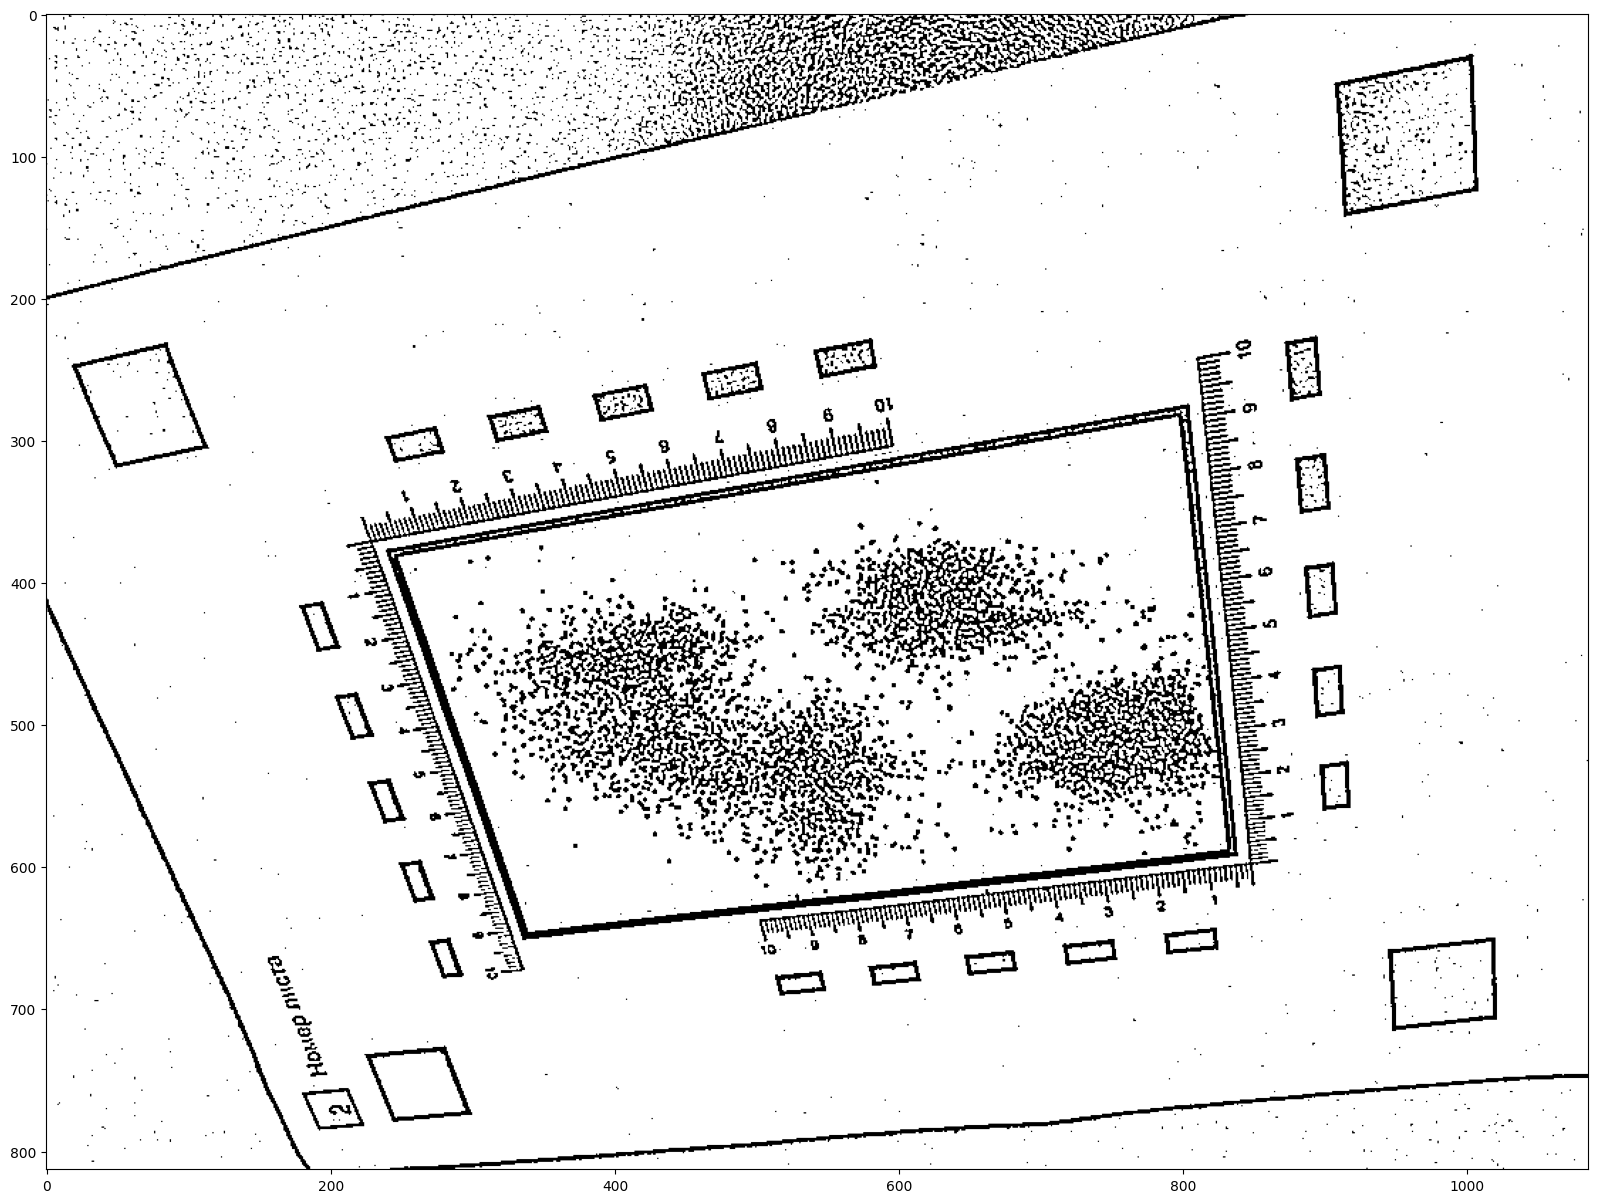

In [30]:
# здесь был код

Теперь обнаружим прямоугольники, по полученному бинаризованному изображению с границами:

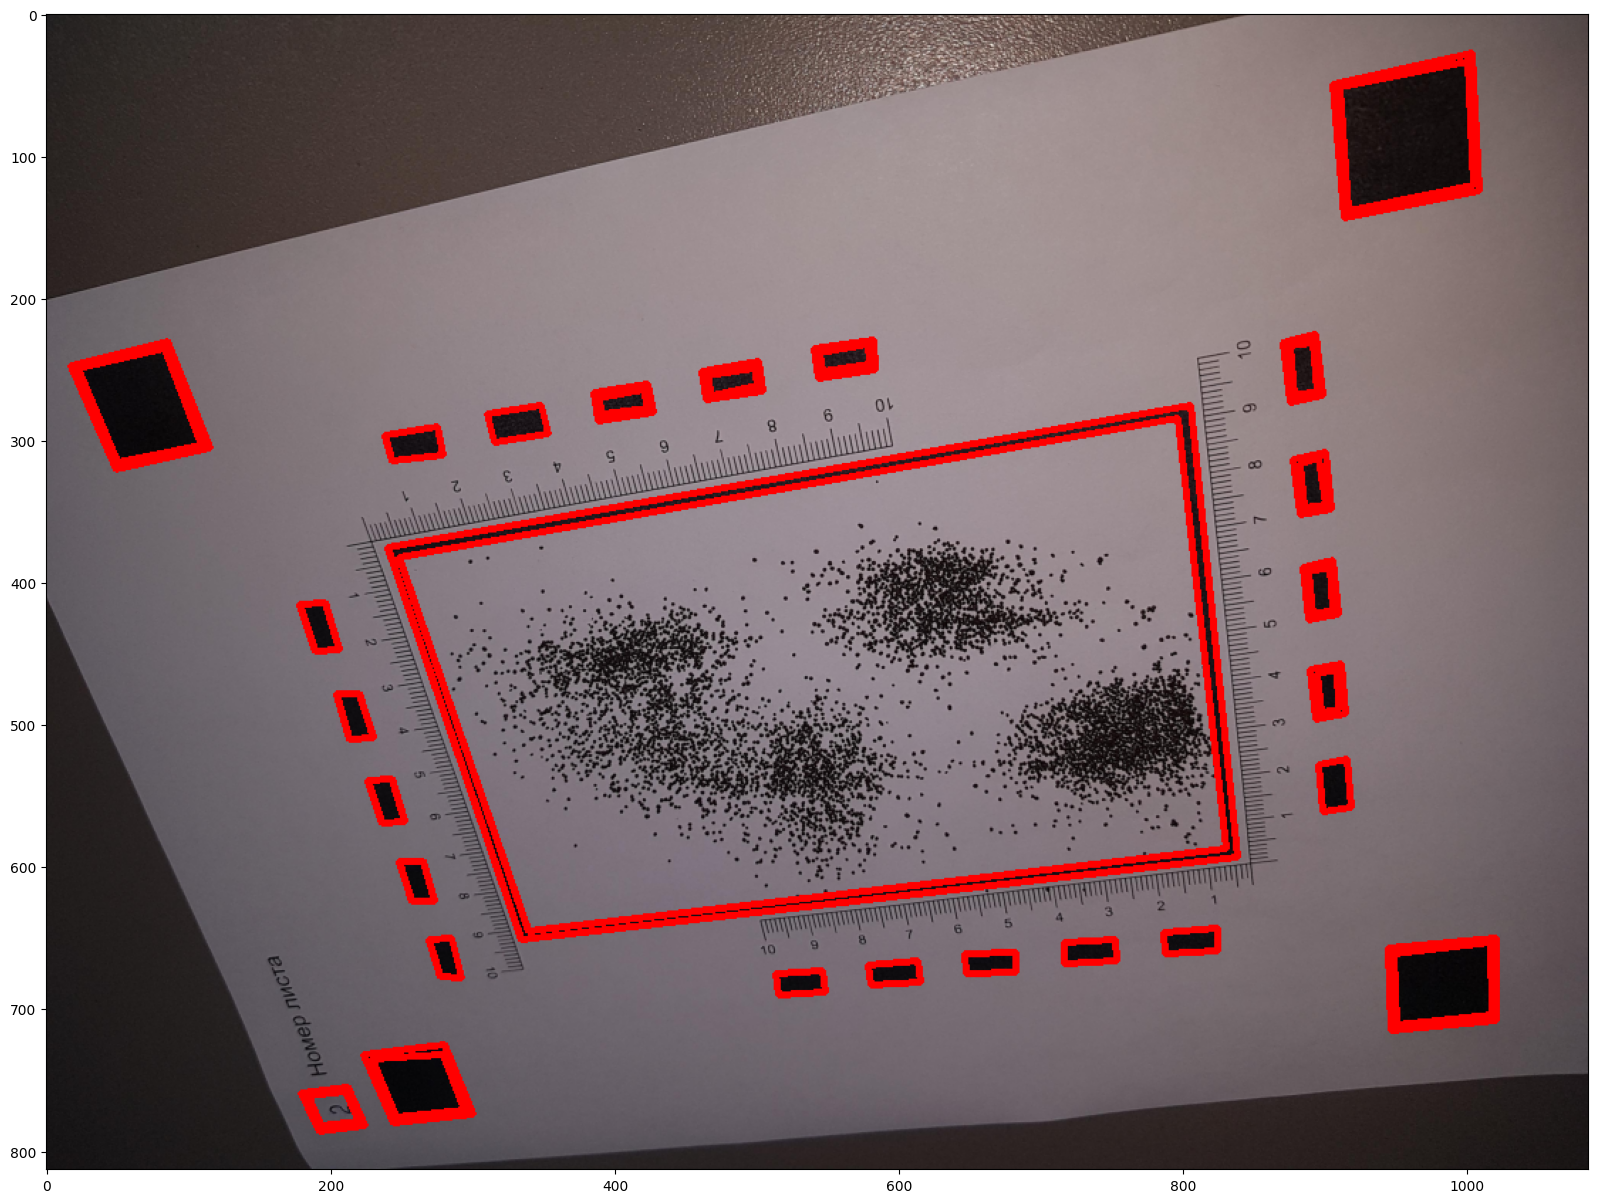

In [31]:
# здесь был код

Остается выделить целевую область с пропаннатом и произвести выравнивание

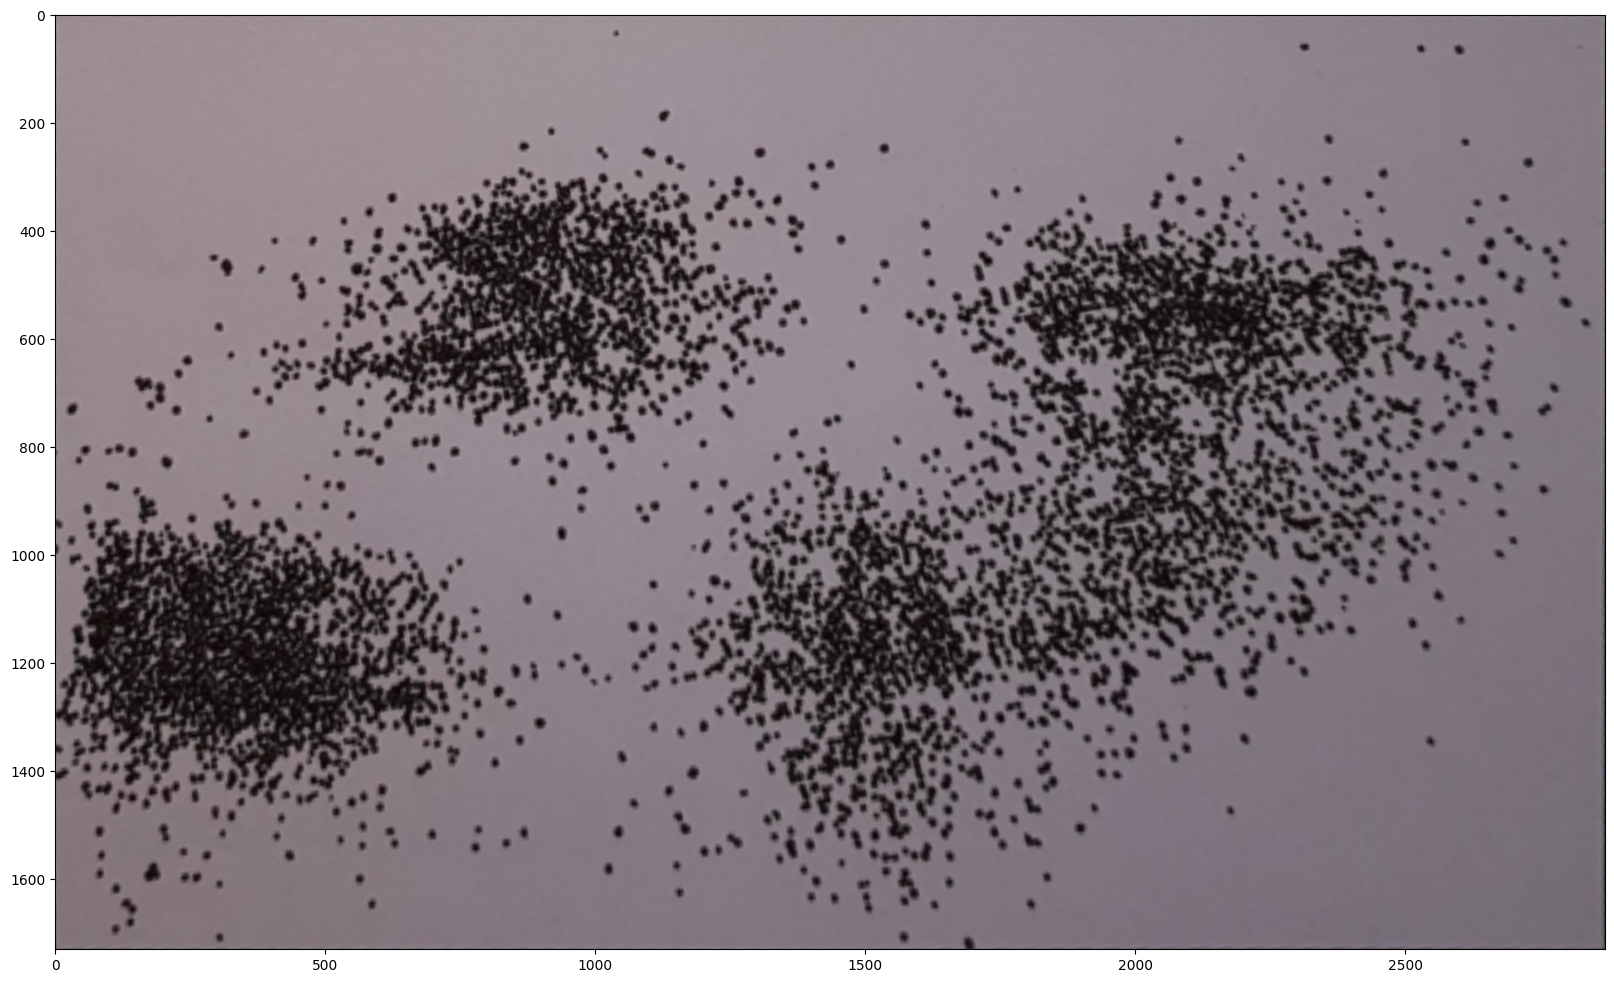

In [32]:
# здесь был код